In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain

In [2]:
# Move to project root
from pathlib import Path
import os

if not Path("./report/figures").is_dir():
    for parent_path in Path.cwd().parents:
        if (parent_path / "report/figures").is_dir():
            os.chdir(parent_path)
            break
    else:
        raise FileNotFoundError("Can't find project root")

assert Path("./report/figures").is_dir()

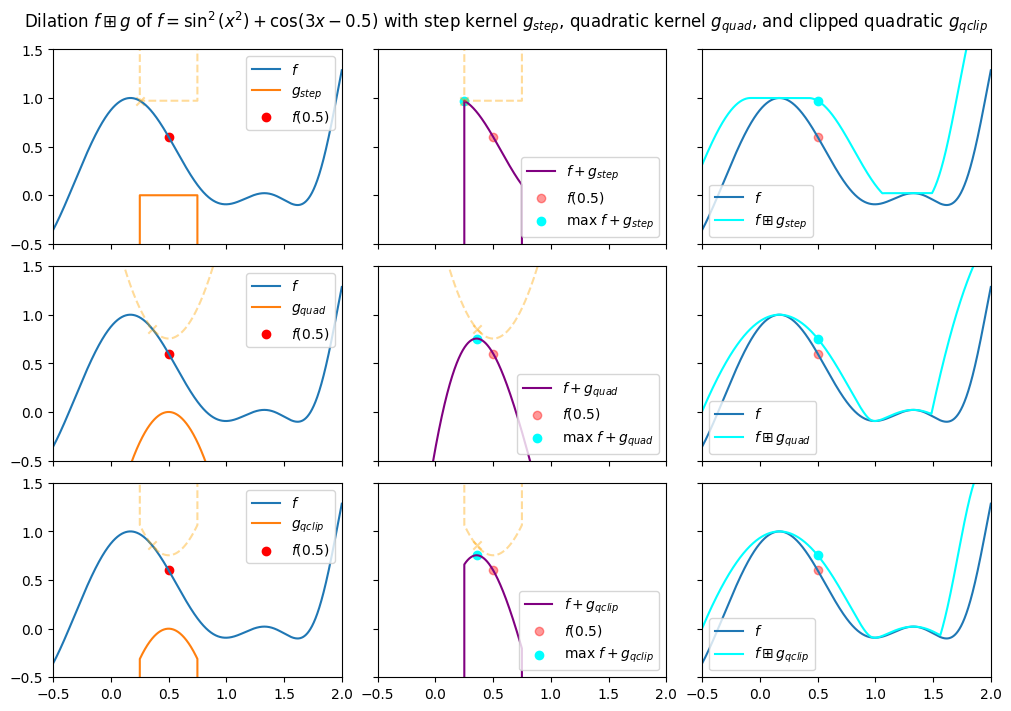

In [174]:
resolution = 1000
xs = np.linspace(-1, 3, num=resolution * 4)


def f_fun(x: float | np.ndarray) -> np.ndarray:
    return np.sin(x**2) ** 2 + np.cos(x * 3 - 0.5)


@np.vectorize(signature=f"()->({len(xs)})", excluded=("scale",))
def step_kernel_around(x: float, scale: float = 0.5):
    g = np.full_like(xs, -9999)
    start = int((x + 1 - scale / 2) * resolution)
    stop = int(start + scale * resolution)
    g[max(start, 0) : min(stop, len(xs))] = 0
    return g


@np.vectorize(signature=f"()->({len(xs)})", excluded=("scale",))
def quad_kernel_around(x: float, scale: float = 5.0):
    return -scale * (xs - x) ** 2


@np.vectorize(signature=f"()->({len(xs)})", excluded=("scale",))
def qclip_kernel_around(x: float, quad_scale: float = 5.0, clip_scale: float = 0.5):
    quadratic = -quad_scale * (xs - x) ** 2
    g = np.full_like(xs, -9999)
    start = int((x + 1 - clip_scale / 2) * resolution)
    stop = int(start + clip_scale * resolution)
    g[max(start, 0) : min(stop, len(xs))] = quadratic[
        max(start, 0) : min(stop, len(xs))
    ]
    return g


f = f_fun(xs)


def dilation_result(g_fun):
    return (f.reshape((1, -1)) + g_fun(xs)).max(axis=1)


fig, (axs_step, axs_quad, axs_qclip) = plt.subplots(
    nrows=3, ncols=3, layout="compressed", figsize=(10, 7), sharex=True, sharey=True
)

fig.suptitle(
    r"Dilation $f \boxplus g$ of $f=\sin^2(x^2) + \cos(3x-0.5)$"
    r" with step kernel $g_{step}$, quadratic kernel $g_{quad}$,"
    r" and clipped quadratic $g_{qclip}$"
)

do_flip_curve = True


def vis_kernel(axs: list[plt.Axes], g_fun, g_name: str, point=0.5):
    g_step = g_fun(point)
    h_step = f + g_step
    max_step = h_step.argmax()

    axs[0].plot(xs, f, label="$f$")
    axs[0].plot(xs, g_step, label=f"$g_{{{g_name}}}$")
    axs[0].scatter(point, f_fun(point), label=f"$f({{{point}}})$", color="red")

    axs[1].plot(xs, h_step, label=f"$f + g_{{{g_name}}}$", color="purple")
    axs[1].scatter(point, f_fun(point), label=f"$f({point})$", color="red", alpha=0.4)
    # axs[1].axhline(h_step[max_step], linestyle="dashed", color="gray", alpha=0.4)
    axs[1].scatter(
        xs[max_step],
        h_step[max_step],
        label=f"$\\max ~f + g_{{{g_name}}}$",
        color="cyan",
    )

    dil_step = dilation_result(g_fun)
    axs[2].plot(xs, f, label="$f$")
    axs[2].plot(xs, dil_step, label=f"$f \\boxplus g_{{{g_name}}}$", color="cyan")
    axs[2].scatter(point, f_fun(point), color="red", alpha=0.4)
    axs[2].scatter(point, dil_step[int((point + 1) * 1000)], color="cyan")

    axs[0].legend(loc="upper right")
    axs[1].legend(loc="lower right")
    axs[2].legend(loc="lower left")

    if do_flip_curve:
        axs[0].plot(
            xs, h_step[max_step] - g_step, color="orange", linestyle="dashed", alpha=0.4
        )
        axs[0].scatter(
            xs[max_step], f_fun(xs[max_step]), color="orange", alpha=0.4, marker="x"
        )
        axs[1].plot(
            xs, h_step[max_step] - g_step, color="orange", linestyle="dashed", alpha=0.4
        )
        axs[1].scatter(
            xs[max_step], f_fun(xs[max_step]), color="orange", alpha=0.4, marker="x"
        )


vis_kernel(axs_step, step_kernel_around, "step")
vis_kernel(axs_quad, quad_kernel_around, "quad")
vis_kernel(axs_qclip, qclip_kernel_around, "qclip")
for ax in chain(axs_step, axs_quad, axs_qclip):
    ax: plt.Axes
    ax.set_xlim(-0.5, 2)
    ax.set_ylim(-0.5, 1.5)

fig.savefig("./report/figures/dilation_illustration.png")
fig.show(warn=False)